### Plotting NetCDF files in Cartopy

Here we explore a workflow that might be used to plot tomography in map view

In [27]:
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd

Take a look at https://www.naturalearthdata.com/features/ for various download options 
and products to link with cfeature

In [3]:
dataset = netcdf_dataset("/Users/rmartinshort/Documents/Berkeley/Python_Maps/netCDF/CASCADE.ANT.GAO-SHEN.2014_kmps.nc")

In [4]:
dataset.summary

'The model is based on a full-wave ambient noise tomographic method and the analysis of Rayleigh waves from ~1000 stations between 1995 to 2012, including the EarthScope USArray Transportable Array and many other permanent and flexible arrays.'

In [5]:
dataset.variables

OrderedDict([('depth', <class 'netCDF4._netCDF4.Variable'>
              float64 depth(depth)
                  long_name: depth below earth surface
                  units: km
                  positive: down
              unlimited dimensions: 
              current shape = (41,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('latitude', <class 'netCDF4._netCDF4.Variable'>
              float64 latitude(latitude)
                  long_name: Latitude; positive north
                  units: degrees_north
                  standard_name: latitude
              unlimited dimensions: 
              current shape = (107,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('longitude', <class 'netCDF4._netCDF4.Variable'>
              float64 longitude(longitude)
                  long_name: Longitude; positive east
                  units: degrees_east
                  standard_name: longitude
          

### Slab contours dataset

In [6]:
slab_contours = netcdf_dataset("/Users/rmartinshort/Documents/Berkeley/Python_Maps/slab_2.0/cas_slab2_dep_02.24.18.grd")

In [9]:
slab_contours.variables

OrderedDict([('x', <class 'netCDF4._netCDF4.Variable'>
              float64 x(x)
                  long_name: x
                  actual_range: [227. 245.]
              unlimited dimensions: 
              current shape = (361,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('y', <class 'netCDF4._netCDF4.Variable'>
              float64 y(y)
                  long_name: y
                  actual_range: [35. 54.]
              unlimited dimensions: 
              current shape = (381,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('z', <class 'netCDF4._netCDF4.Variable'>
              float32 z(y, x)
                  long_name: z
                  _FillValue: nan
                  actual_range: [-437.01348877   -4.69993925]
              unlimited dimensions: 
              current shape = (381, 361)
              filling on)])

In [10]:
depth_to_slab = slab_contours.variables['z'][:,:]
slab_depth_lats = slab_contours.variables['y'][:]
slab_depth_lons = slab_contours.variables['x'][:]

In [12]:
depth_slice = 30
vs = dataset.variables['vs'][depth_slice,:,:]
lons = dataset.variables['longitude'][:]
lats = dataset.variables['latitude'][:]

### Global volcanoes dataset

In [28]:
#Get this data from https://earthworks.stanford.edu/catalog/harvard-glb-volc
volcanoes = gpd.read_file('volcanoes/harvard-glb-volc-geojson.json')

In [29]:
volcanoes.head()

,id,NUMBER_,NAME_,LOCATION,LAT,LON,ELEV,TYPE_,STATUS,TIME_FRAME,geometry
0,GLB_VOLC.1,0100-01-,WEST EIFE,Germany,50.17,6.85,600,Maars,Radiocarb,D7,POINT (6.85000007 50.16789464)
1,GLB_VOLC.2,0100-02-,CHAINE DE,France,45.50,2.75,1464,Cinder co,Radiocarb,D7,POINT (2.75000007 45.49785949)
2,GLB_VOLC.3,0100-03-,OLOT VOLC,Spain,42.17,2.53,893,Pyroclast,Holocene?,?,POINT (2.53000006 42.16786921)
3,GLB_VOLC.4,0101-001,LARDERELL,Italy,43.25,10.87,500,Explosion,Historica,D6,POINT (10.8699999 43.24786285)
4,GLB_VOLC.5,0101-002,AMIATA,Italy,42.90,11.63,1738,Lava dome,Pleistoce,Q,POINT (11.62999999 42.89786467)


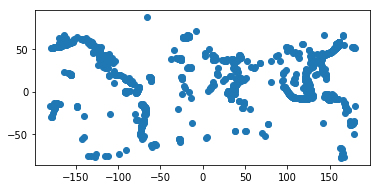

In [31]:
#Easy way of plotting the volcano locations
volcanoes.plot();

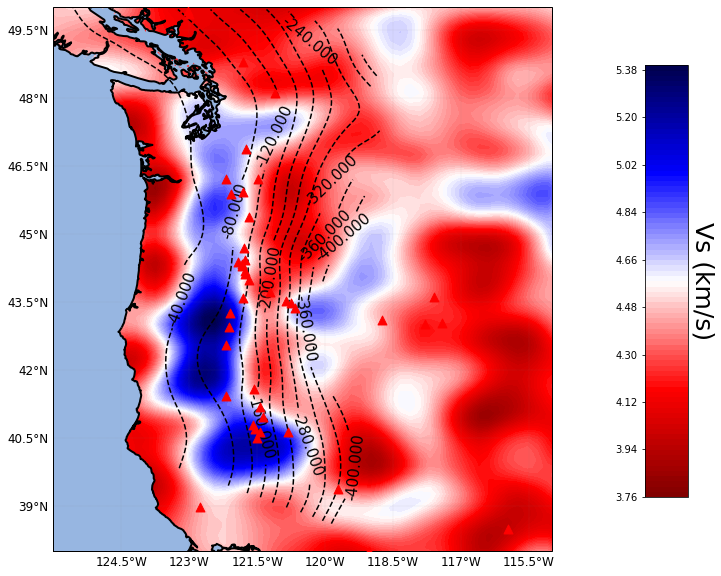

In [44]:
minlon = -126
maxlon = -115
minlat = 38
maxlat = 50

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent([minlon, maxlon, \
               minlat, maxlat])

#Get ocean feature so that we can mask out the sea. This can take 
#a while to download
ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean',
                            scale='10m', facecolor=cfeature.COLORS['water'])
ax.add_feature(ocean)

#Bathymetry features don't work very well. Could just contour bathymetry
#from netCDF as we do in GMT
#bathy = cfeature.NaturalEarthFeature(name='bathymetry_E_200',
#                                  scale='10m', category='physical')
#ax.add_feature(bathy)


#This is where plot the tomography depth slice
tomo = plt.contourf(lons, lats, vs, 100,
             transform=ccrs.PlateCarree(),cmap='seismic_r')

#This is where plot the slab depth contours.
slab = plt.contour(slab_depth_lons, slab_depth_lats, depth_to_slab, 10,
             transform=ccrs.PlateCarree(),colors='k')
#Label the slab contours
ax.clabel(slab, inline=1, fontsize=15)

ax.coastlines(resolution='10m',linewidth=2)

#plot the volcanoes
ax.scatter(volcanoes['LON'],volcanoes['LAT'],transform=proj,s=80,marker='^',\
           c='red',zorder=10)

gl = ax.gridlines(crs=proj, draw_labels=True,
            linewidth=0.1, color='gray', alpha=1, linestyle='--')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right= False 

bar_ax = fig.add_axes([0.75, 0.2, 0.03, 0.6])

cbar = plt.colorbar(tomo,cax=bar_ax)
bar_ax.yaxis.set_ticks_position('left')
bar_ax.yaxis.set_label_position('right')
cbar.set_label('Vs (km/s)', rotation=270,fontsize=25,labelpad=27)
